# Desafio Cientista de Dados -  Indicium

**Author: Ismael Alves Lima**

This paper presents an exploratory data analysis (EDA) of short-term rentals in New York City, with the goal of developing a predictive model for prices.

## Problem Description

You have been assigned to an Indicium team that is currently working with a client on the process of creating a short-term rental platform in New York City. In order to develop your pricing strategy, you have asked Indicium to perform an exploratory analysis of your largest competitor's data, as well as a validation test of a predictive model.

**Your goal is to develop a price prediction model from the provided dataset, and evaluate this model using the evaluation metrics that make the most sense for the problem.** The use of other data sources in addition to the dataset is permitted (and encouraged). A dictionary of the data can be found attached. More details in [Descrição.md](Descrição.md)

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

## Data Overview

The dataset provided is composed of advertisements, with information about the listed properties, such as location, property type, prices, number of reviews, among others. From this data, we will seek to identify patterns, trends and factors that influence rental prices, in addition to validating a forecasting model that can be used for pricing strategies.

In [2]:
dataset = pd.read_csv('Data/teste_indicium_precificacao.csv')

In [3]:
dataset.head(3)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


## Exploring the Data - Part 1

### About data types

This section provides an overview of the data types present in the New York City short-term rentals dataset. The dataset contains 48,894 entries and 16 columns, with variables of different types, including strings, floats, and integers. Each data type and its characteristics are detailed below.

The data includes variables of different types:

* **Strings**: `nome`, `host_name`, `bairro_group`, `bairro`, `room_type`, `ultima_review` (Date)

* **Floats**: `latitude`, `longitude` (geographic data), `reviews_por_mes`

* **Integers**: `id`, `host_id`, `price`, `minimo_nottes`, `numero_de_reviews`, `calculado_host_listings_count`, `disponibilidade_365`

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

### About missing data

This section discusses the analysis of missing data in the dataset. The presence of missing values ​​in some columns will be identified and the possible causes and appropriate treatments for these cases will be discussed.

In [5]:
dataset.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Missing data was identified in the following columns:

* `nome`: 16 missing values ​​(0.0003% of data)

* `host_name`: 21 missing values ​​(0.0004% of data)

* `ultima_review`: 10,052 missing values ​​(20% of data)

* `reviews_por_mes`: 10,052 missing values ​​(20% of data)

In [6]:
dataset[dataset['ultima_review'].isna() | dataset['reviews_por_mes'].isna()]['numero_de_reviews'].value_counts()

numero_de_reviews
0    10052
Name: count, dtype: int64

In [7]:
dataset.drop(columns=['ultima_review', 'reviews_por_mes'], inplace=True)

The missing values ​​in `ultima_review` and `reviews_por_mes` correspond to the same entries, suggesting that they may be new listings or listings from individuals who have not yet received reviews. **Removing all entries with missing values** would result in 20% of the data being missing, which is not ideal. Therefore, **the `ultima_review` and `reviews_por_mes` columns have been removed** as the nature of these missing data may be related to new listings and filling them in could introduce unnecessary bias or noise into the model.

This analysis allowed us to identify and treat missing data appropriately, ensuring the quality of the dataset for the next modeling steps. The decision to remove the `ultima_review` column, as it is a dated column and this makes it difficult to fill, was made to avoid introducing bias into the predictive model. In addition, filling in the missing data in `reviews_por_mes` could generate incompatibility with the `number_of_reviews` column and this would make it difficult for the models to learn. The missing data for `name` and `host_name` will be treated later.

## Exploring the Data - Part 2

### About Columns

This section explores each column of the dataset separately, analyzing its characteristics and creating graphs of statistical measures when applicable. Initially, an overview of the columns and the types of data contained in them will be presented.

For the categorical columns, we have:

* `bairro_group`: nominal categorical

* `bairro`: nominal categorical

* `room_type`: nominal categorical


For the numeric columns, we have

* `latitude`: continuous numeric

* `longitude`: continuous numeric

* `price`: discrete numeric

* `minimo_noites`: discrete numeric

* `numero_de_reviews`: discrete numeric

* `calculado_host_listings_count`: discrete numeric

* `disponibilidade_365`: discrete numeric

In addition to these, there are also columns identifying the listing (`id` and `nome`) and the owner (`host_id` and `host_name`).

Below are the first rows of categorical and string columns, and the first rows of numeric and identifier columns, classified as type 'object' and 'number' in Pandas, respectively.

In [8]:
dataset.select_dtypes(include='object').head()

,nome,host_name,bairro_group,bairro,room_type
0,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt
1,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,Private room
2,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt
3,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt
4,Large Cozy 1 BR Apartment In Midtown East,Chris,Manhattan,Murray Hill,Entire home/apt


In [9]:
dataset.select_dtypes(include='number').head()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
0,2595,2845,40.75362,-73.98377,225,1,45,2,355
1,3647,4632,40.80902,-73.94190,150,3,0,1,365
2,3831,4869,40.68514,-73.95976,89,1,270,1,194
3,5022,7192,40.79851,-73.94399,80,10,9,1,0
4,5099,7322,40.74767,-73.97500,200,3,74,1,129


We note that categorical columns, such as `bairro_group` and `room_type`, can be useful for segmented analysis. Numeric columns, such as `price` and `número_de_reviews`, are essential for predictive modeling. The `id` column is unique for each entry, which makes it useful for identification, but not for statistical analysis. The `calculado_host_listings_count` column contains the number of listings per host and can help us identify, for example, the existence of individuals and companies specializing in property rentals.

In [10]:
dataset_hosts = dataset.drop_duplicates(subset='host_id', keep='first')
dataset_hosts.shape

(37457, 14)

In [11]:
dataset['calculado_host_listings_count'].value_counts()[:10]

calculado_host_listings_count
1      32303
2       6658
3       2853
4       1440
5        845
6        569
8        416
7        399
327      327
9        234
Name: count, dtype: int64

In [12]:
dataset[dataset['calculado_host_listings_count'] == 327][['host_id','host_name']].iloc[0]

host_id         219517861
host_name    Sonder (NYC)
Name: 38292, dtype: object

In [13]:
dataset[dataset['calculado_host_listings_count'] == 232][['host_id','host_name']].iloc[0]

host_id       107434423
host_name    Blueground
Name: 26136, dtype: object

By analyzing the unique appearances of each `host_id`, we can see that the number of hosts is smaller than the total amount of data, which may be an indication of the existence of specialized companies, and from the count made this hypothesis can be confirmed. By searching the data and on the internet, it is possible to verify the existence of companies in the data, such as the companies "[Sonder](https://www.sonder.com/destinations/new_york_city/search?sleeps=1&neighborhood=all_neighborhoods&bedroom_count=0&bed_count=1&bathroom_count=1) (NYC)" and "[Blueground](https://www.theblueground.com)", in addition, most of the hosts advertised only once, which are probably people advertising their own properties.

#### Categorical Variables

This section separately explores the categorical variables present in the dataset, analyzing the distribution of categories in each column. A large discrepancy in the number of ads between different categories was observed, which can be explained by several factors related to the business.

In [14]:
dataset['bairro_group'].value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

`bairro_group`: Most of the ads are concentrated in Manhattan and Brooklyn, which can be explained by the high [population density](https://pt.wikipedia.org/wiki/Nova_Iorque#:~:text=Manhattan%2C%20Condado%20de%20Nova%20Iorque%2C%20%C3%A9%20o%20centro%20econ%C3%B4mico%20da%20cidade%2C%20e%20tamb%C3%A9m%20onde%20a%20cidade%20de%20Nova%20Iorque%20possui%20suas%20origens.%20%C3%89%20o%20distrito%20mais%20densamente%20habitado%20de%20Nova%20Iorque%20(%C3%A9%20o%20condado%20mais%20densamente%20habitado%20do%20pa%C3%ADs)%2C%20e%20onde%20se%20localizam%20a%20maioria%20dos%20arranha%2Dc%C3%A9us%20da%20cidade.) and the presence of important [tourist attractions](https://pt.wikipedia.org/wiki/Manhattan#Censo_2020:~:text=%5B25%5D-,Características,pontos%20turísticos%20americanos%20mais%20conhecidos%20e%20visitados%20dos%20Estados%20Unidos.,-Organização).

In [15]:
dataset['bairro'].value_counts()

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Richmondtown             1
Fort Wadsworth           1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64

`bairro`: The distribution of ads by neighborhood shows a wide variety, with some neighborhoods having significantly more ads. This column is heavily influenced by the previous one, as the top five neighborhoods are in the boroughs of Brooklyn and Manhattan.

In [16]:
dataset['room_type'].value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

`room_type`: The majority of listings are of the 'Entire home/apt' type, followed by 'Private room' and 'Shared room'. The predominance of 'Entire home/apt' and 'Private room' in `room_type` can be attributed to guests' preference for more privacy and space.

#### Numerical Variables

This section explores the numerical variables present in the dataset, analyzing their distributions and identifying the presence or absence of outliers. This detailed analysis can help us understand specific characteristics of each column and the behavior of the data, in addition to providing us with insights into the business.

Note: To better visualize the behavior of the variables, graphs with and without outliers were created in this section, on the left and right, respectively.

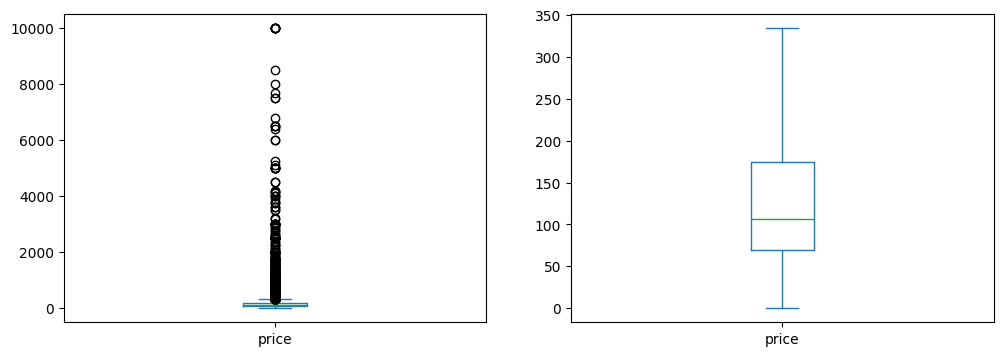

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

dataset['price'].plot.box(ax=ax[0])
dataset['price'].plot.box(showfliers=False, ax=ax[1])

plt.show()

In [18]:
dataset['price'].describe()

count    48894.000000
mean       152.720763
std        240.156625
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

`price`: We observed a large number of outliers. The occurrence of outliers, in this case, may be due to errors in data collection, in the creation of the advertisements themselves, or, in the best case scenario, may occur naturally due to characteristics of the properties that affect the price, such as location, space, capacity, etc. By removing the outliers (graph on the right), the price distribution becomes more homogeneous, but an asymmetry of the 'box' in relation to the 'whiskers' is noticeable. Furthermore, when looking at the result of the 'describe()' function, we can notice an inconsistency in the data, since the minimum value for the variable is 0.

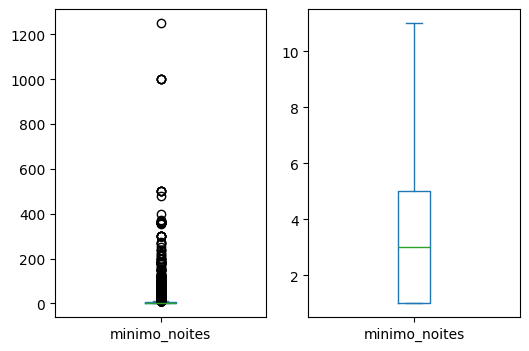

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

dataset['minimo_noites'].plot.box(ax=ax[0])
dataset['minimo_noites'].plot.box(showfliers=False, ax=ax[1])

plt.show()

In [20]:
dataset['minimo_noites'].describe()

count    48894.000000
mean         7.030085
std         20.510741
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimo_noites, dtype: float64

`minimo_noites`: The distribution shows that most listings have a low minimum number of nights, but there are some outliers with very high values. This can happen in situations where the owner establishes a contract with a minimum number of months for the stay, usually in house or apartment rentals.

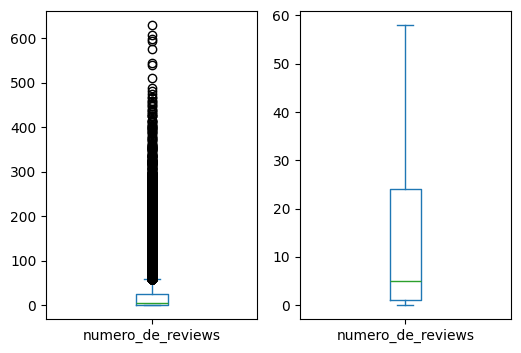

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

dataset['numero_de_reviews'].plot.box(ax=ax[0])
dataset['numero_de_reviews'].plot.box(showfliers=False, ax=ax[1])

plt.show()

In [22]:
dataset['numero_de_reviews'].describe()

count    48894.000000
mean        23.274758
std         44.550991
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: numero_de_reviews, dtype: float64

`numero_de_reviews`: This variable also has many outliers, indicating ads that have received a significantly higher number of reviews, which may indicate ads for places with many visits.

<Axes: >

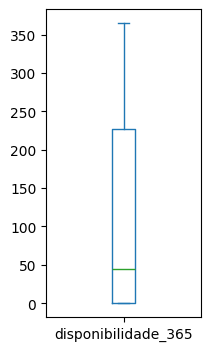

In [23]:
dataset['disponibilidade_365'].plot.box(figsize=(2, 4))

In [24]:
dataset['disponibilidade_365'].describe()

count    48894.000000
mean       112.776169
std        131.618692
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: disponibilidade_365, dtype: float64

`disponibilidade_365`: Most properties are available for booking most of the year, with some properties having limited availability, possibly due to high demand or specific owner policies. As with the `price` variable, this variable presents an inconsistency, as the minimum value is 0, which would imply that the place would not be available any day of the year, and not only that, the 25% quantile is also 0, which indicates that there is a lot of data in this condition.

This analysis of the numerical variables provided important insights into the distribution of prices, minimum nights, number of reviews, reviews per month and listing availability. The presence of outliers in several variables indicates the need for careful treatment of these data to avoid bias in the predictive modeling. In this case, it is clear that the outlier data is actually directly related to the business. Thus, the removal of these outliers will be done for strategic modeling purposes, with the aim of improving the efficiency of the model.

## Exploring the Data - Part 3

### About Price

This section first explores the relationships between the target variable (`price`) and some variables in the dataset. Through visualizations, we seek to identify patterns and trends that may influence the prices of temporary rentals in New York.

Note: To better visualize the behavior of the variables, in this section graphs were created with and without outliers, on the left and right, respectively.

Text(0.5, 1.0, 'Price variation of bairro_group without outliers')

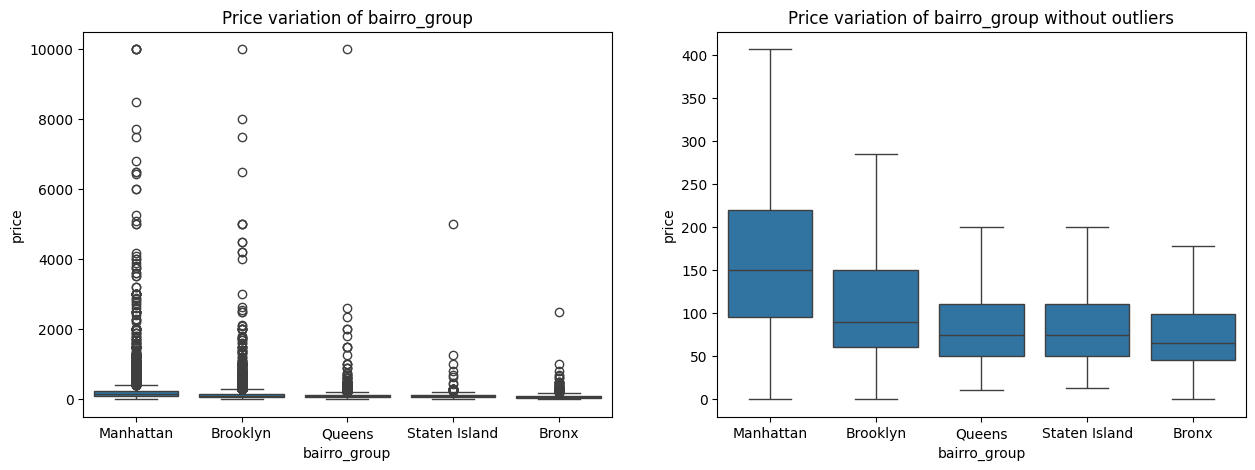

In [25]:
var = 'bairro_group'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=dataset, x=var, y='price', ax=axes[0])
sns.boxplot(data=dataset, x=var, y='price', showfliers=False, ax=axes[1])

axes[0].set_title(f'Price variation of {var}')
axes[1].set_title(f'Price variation of {var} without outliers')

`bairro_group`: We observed that prices vary significantly between boroughs, with Manhattan having the highest prices and the Bronx the lowest.

Text(0.5, 1.0, 'Price variation of room_type without outliers')

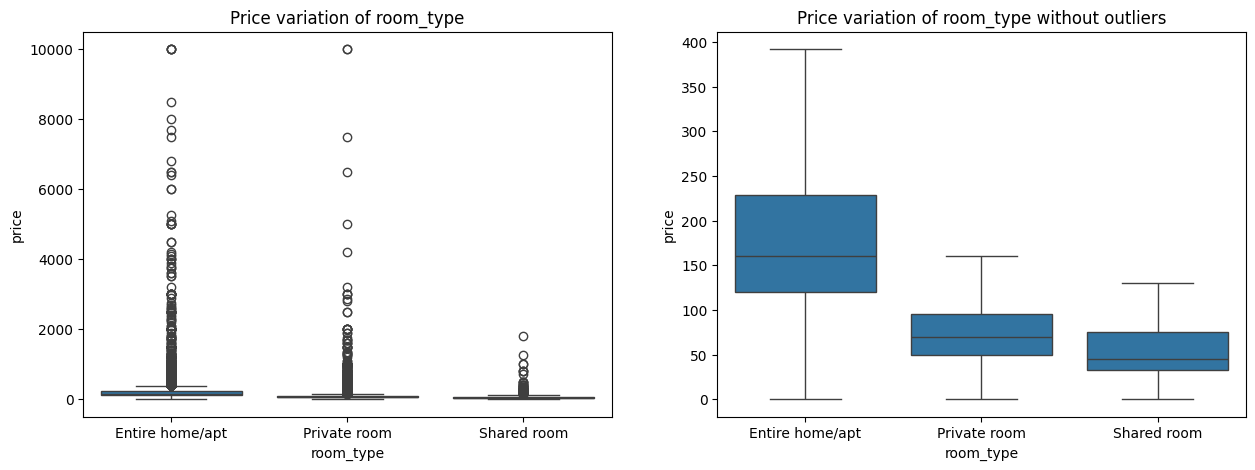

In [26]:
var = 'room_type'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=dataset, x=var, y='price', ax=axes[0])
sns.boxplot(data=dataset, x=var, y='price', showfliers=False, ax=axes[1])

axes[0].set_title(f'Price variation of {var}')
axes[1].set_title(f'Price variation of {var} without outliers')

`room_type`: The room type also influences the price, with 'Entire home/apt' being the most expensive, followed by 'Private room' and 'Shared room'.

Text(0.5, 0.98, 'Price distribution over latitude and longitude')

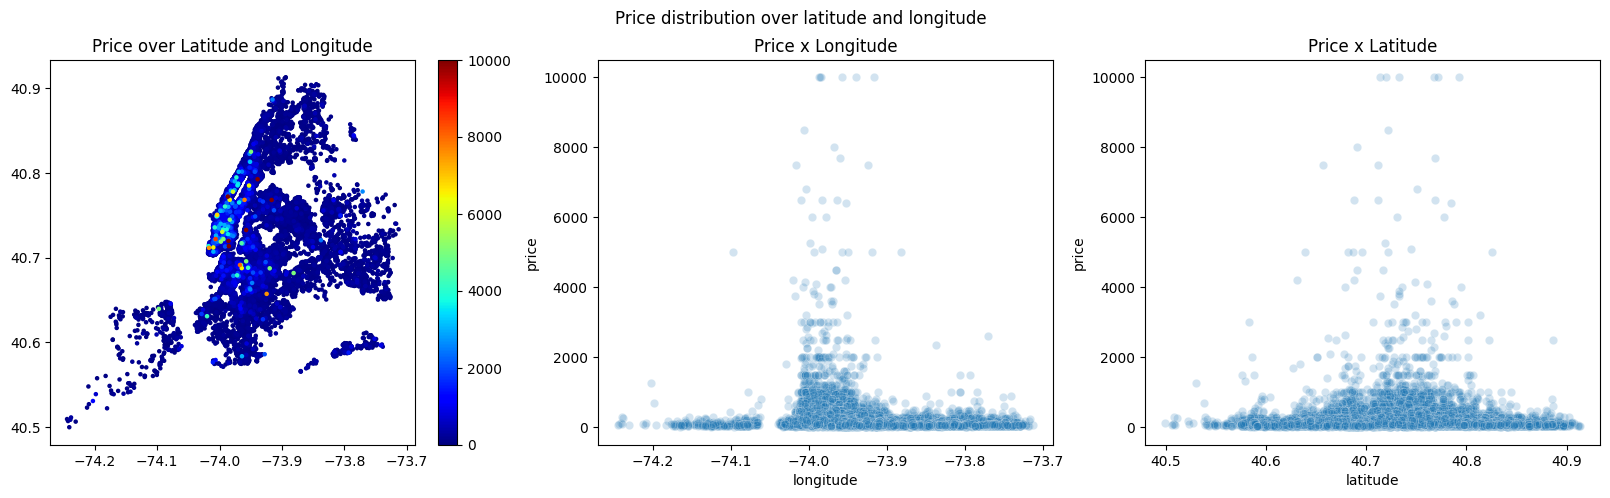

In [27]:
dataset_sorted = dataset.sort_values(by="price", ascending=True)

fig, ax = plt.subplots(1,3,figsize=(20, 5))

colormap = ax[0].scatter(dataset_sorted['longitude'], dataset_sorted['latitude'], c = dataset_sorted['price'], alpha = 1, cmap ='jet', s=5)
sns.scatterplot(data=dataset, y='price', x='longitude', alpha=0.2, ax=ax[1], legend=False)
sns.scatterplot(data=dataset, y='price', x='latitude', alpha=0.2, ax=ax[2], legend=False)

cbar = plt.colorbar(colormap, ax=ax[0])

ax[0].set_title('Price over Latitude and Longitude')
ax[1].set_title('Price x Longitude')
ax[2].set_title('Price x Latitude')

fig.suptitle('Price distribution over latitude and longitude')

`latitude` and `longitude`: The geographic location of properties has a considerable impact on price, with central areas like Manhattan having higher prices.

Conclusions:

* Prices vary significantly between boroughs, with Manhattan having the highest prices, followed by Brooklyn, Queens, Staten Island and the Bronx. This can be explained by Manhattan’s high demand and prime location.

* In terms of room type, ‘Entire home/apt’ is the most expensive, reflecting guests’ preference for more privacy and space.

* Geographic location also has a considerable impact, with central areas having higher prices.

### About the other variables

Now, the relationships between the non-target variables of the dataset will be explored, seeking to identify patterns and trends that can provide additional insights into the data, seeking to understand how different variables relate to each other.

Text(0.5, 0.98, 'room_type distribution')

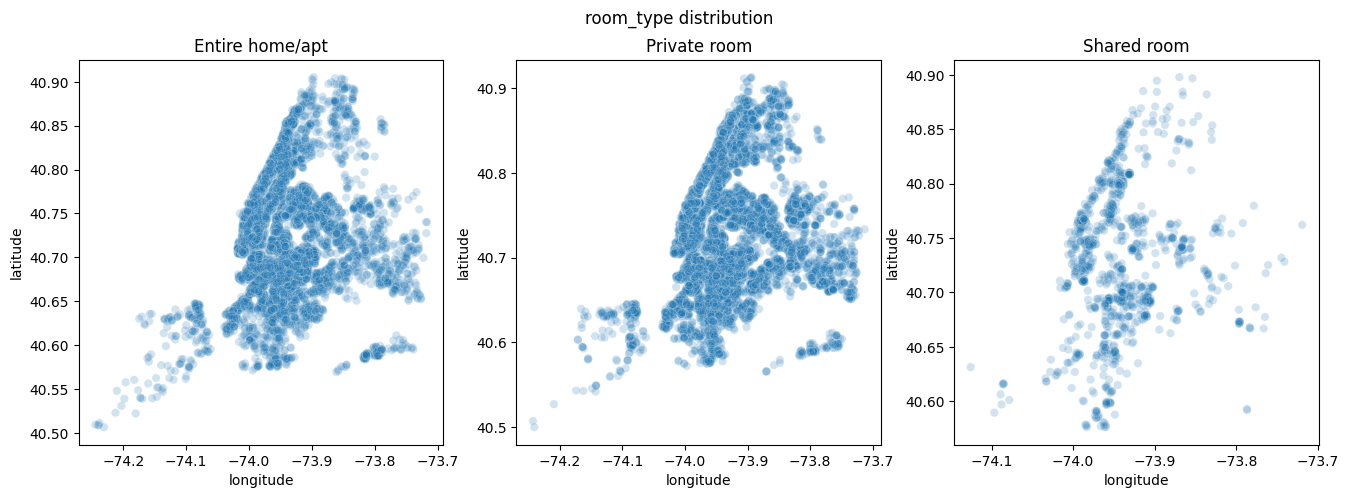

In [28]:
fig, ax = plt.subplots(1,3,figsize=(16, 5))

sns.scatterplot(data=dataset[dataset['room_type'] == 'Entire home/apt'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[0], legend=False)
sns.scatterplot(data=dataset[dataset['room_type'] == 'Private room'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[1], legend=False)
sns.scatterplot(data=dataset[dataset['room_type'] == 'Shared room'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[2], legend=False)

ax[0].set_title('Entire home/apt')
ax[1].set_title('Private room')
ax[2].set_title('Shared room')

fig.suptitle('room_type distribution')

`room_type` and `latitude`/`longitude`: The distribution of room types is relatively homogeneous across the city, with 'Entire home/apt' and 'Private room' being the most common, while 'Shared room' is less frequent.

Text(0.5, 1.0, 'room_type x numero_de_reviews *without outliers')

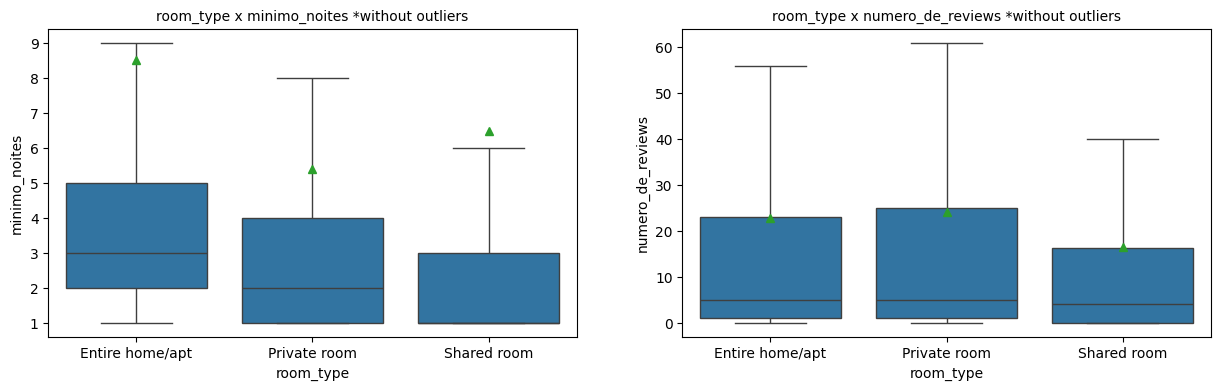

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=dataset, x='room_type', y='minimo_noites', showfliers=False, ax=axes[0], showmeans=True)
sns.boxplot(data=dataset, x='room_type', y='numero_de_reviews', showfliers=False, ax=axes[1], showmeans=True)

axes[0].set_title(f'room_type x minimo_noites *without outliers', fontsize=10)
axes[1].set_title(f'room_type x numero_de_reviews *without outliers', fontsize=10)

`room_type` and `minimo_noites`: Entire home/apts tend to have a higher minimum number of nights compared to private rooms and shared rooms. An important point is that for all room types the average minimum number of nights is outside the box, indicating a distortion in the distribution due to outliers.

`room_type` and `numero_de_reviews`: Private rooms have a slightly higher number of reviews than other room types.


Text(0.5, 1.0, 'bairro_group x numero_de_reviews *without outliers')

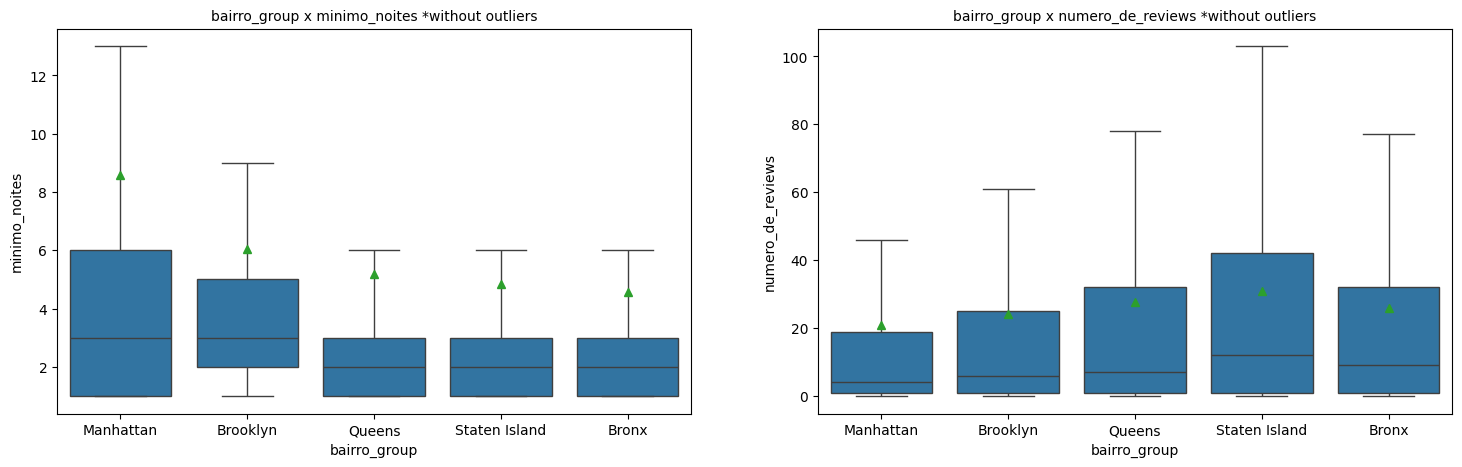

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.boxplot(data=dataset, x='bairro_group', y='minimo_noites', showfliers=False, ax=axes[0], showmeans=True)
sns.boxplot(data=dataset, x='bairro_group', y='numero_de_reviews', showfliers=False, ax=axes[1], showmeans=True)

axes[0].set_title(f'bairro_group x minimo_noites *without outliers', fontsize=10)
axes[1].set_title(f'bairro_group x numero_de_reviews *without outliers', fontsize=10)

`bairro_group` e `minimo_noites`: Manhattan is the borough with the highest average minimum number of nights. Queens, Staten Island and the Bronx have very similar distributions.

`bairro_group` e `numero_reviews`: Staten Island has a statistically higher number of reviews than the other boroughs.

Conclusions:

* The distribution of 'Entire home/apt' and 'Private room' room types is relatively even across the city, with 'Shared room' being much more sparse.

* Private rooms tend to have slightly higher reviews, possibly due to more interaction between guests and hosts.

* Staten Island has a statistically higher number of reviews, which may be indicative of a more active guest base or policies that encourage reviews.

* Manhattan has a slightly higher minimum night stay, possibly reflecting higher demand, more restrictive hosting policies, or higher footfall due to tourism in the area.

### Correlation Map

In [31]:
# Encoding of categorical variables
df_encoded = pd.concat((dataset, pd.get_dummies(dataset['room_type'], dtype=int), pd.get_dummies(dataset['bairro_group'], dtype=int)), axis=1).drop(columns=['room_type', 'bairro_group'])

# Selecting only numeric variables
df_encoded = df_encoded.select_dtypes(include=['number']).drop(columns=['id','host_id'])

# Changing the order of the columns by making the price the first
colunas = ['price'] + [coluna for coluna in df_encoded.columns if coluna != 'price']
df_encoded = df_encoded[colunas]
df_encoded.head()

,price,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,225,40.75362,-73.98377,1,45,2,355,1,0,0,0,0,1,0,0
1,150,40.80902,-73.94190,3,0,1,365,0,1,0,0,0,1,0,0
2,89,40.68514,-73.95976,1,270,1,194,1,0,0,0,1,0,0,0
3,80,40.79851,-73.94399,10,9,1,0,1,0,0,0,0,1,0,0
4,200,40.74767,-73.97500,3,74,1,129,1,0,0,0,0,1,0,0


<Axes: >

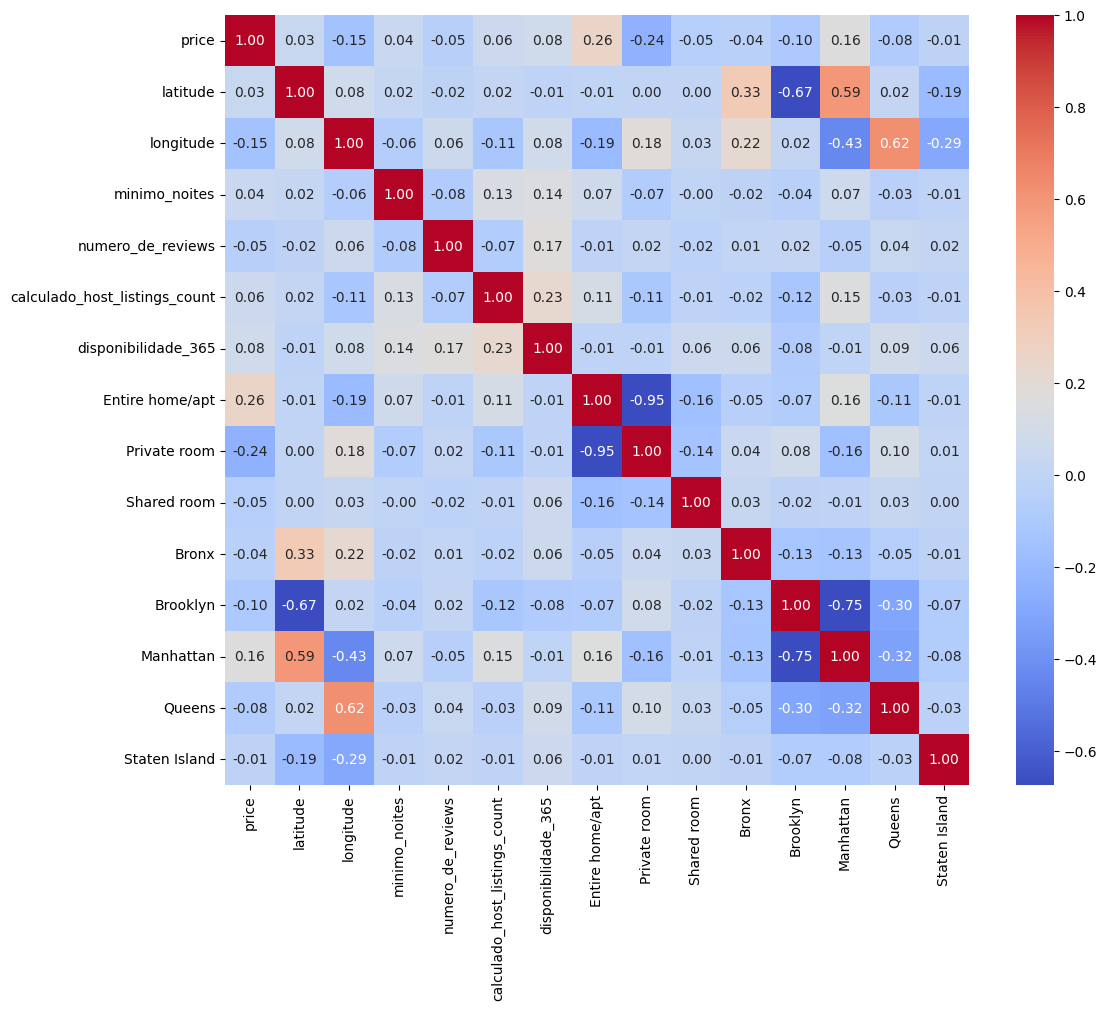

In [32]:
matrix_corr = df_encoded.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(matrix_corr, annot=True, cmap="coolwarm", fmt=".2f", robust=True)

Looking at the correlation map we can see that the variable `price` does not present a high correlation coefficient with any variable, however we can observe that there is a correlation, albeit weak, between `price` and the variables related to the type of property (`Entire home/apt` and `Private room`) and locations (`Manhattan` and `Brooklyn`). In addition, the variables related to `bairro_group` present a moderate correlation with `latitude` and `longitude`.

Analyzing the relationships between the target variable (`price`) and other variables provided us with important insights into the factors that influence the prices of temporary rentals in New York. In addition, it was also possible to understand how non-target variables relate to each other, and this information will be useful for the predictive modeling stage.

## Answering the Questions:

#### 1. Assuming that a person is thinking about investing in an apartment to rent on the platform, where would be the most appropriate place to buy?

This is a difficult question because to determine the best district to invest in an apartment to rent on the platform, several factors must be considered, such as population density, connectivity, tourist attraction, security and real estate market. We will analyze each district and identify the best investment options. In addition, the final choice will depend largely on the investor's profile.

Below will be listed the pros and cons for each district in New York City, and at the end will be given the author's opinion on the subject.

* Manhattan:
    * Pros:
        * Home to New York's most famous [landmarks](https://en.wikipedia.org/wiki/Manhattan#Tourism:~:text=O%20turismo%20%C3%A9,%5B%20228%20%5D);
        * Economy: The city's economic hub, [highest per capita income in the US](https://en.wikipedia.org/wiki/Manhattan#Economy:~:text=Manhattan%20%C3%A9%20o%20motor%20econ%C3%B4mico%20da%20cidade%20de%20Nova%20York);
        * Accessibility, the district has a modern [public transportation](https://en.wikipedia.org/wiki/Manhattan#Infrastructure:~:text=Public%20transportation%5B,in%20New%20Jersey.) system;
        * It is recognized that [real estate](https://en.wikipedia.org/wiki/Manhattan#Real_estate:~:text=O%20mercado%20imobili%C3%A1rio,em%20Midtown%20Manhattan.) is one of the pillars of Manhattan's economy, which can lead to an increase in the value of the property that was invested in;
    * Cons:
        * The analyses above show that property values ​​are high, which would lead to a high initial investment;
        * For a more conservative investor, competition can be a problem, since as we have seen, the real estate market is already well established;

* Brooklyn:
    * Pros:
        * The district has highly valued areas, such as the [Williamsburg](https://en.wikipedia.org/wiki/Williamsburg,_Brooklyn) neighborhood;
        * In addition to the vast [cultural diversity](https://en.wikipedia.org/wiki/Culture_of_Brooklyn), the vibrant environment is very attractive to tourists;

    * Cons:
        * High population density, it is the [most populous district in the city](https://en.wikipedia.org/wiki/Brooklyn#:~:text=As%20of%20the%202020%20United%20States%20census%2C%5B1%5D%20the%20population%20stood%20at%202%2C736%2C074%2C%20making%20it%20the%20most%20populous%20of%20the%20five%20boroughs%20of%20New%20York%20City%2C%20and%20the%20most%20populous%20county%20in%20the%20state.%5B5%5D%5B6%5D%5B7%5D);
        * Urban mobility, accessibility and [public transportation](https://en.wikipedia.org/wiki/Brooklyn#Transportation:~:text=Aproximadamente%2092%2C8%25%20dos%20moradores%20do%20Brooklyn%20que%20viajam%20para%20Manhattan%20usam%20o%20metr%C3%B4%2C%20apesar%20do%20fato%20de%20alguns%20bairros%20como%20Flatlands%20e%20Marine%20Park%20serem%20mal%20atendidos%20pelo%20servi%C3%A7o%20de%20metr%C3%B4.%20As%20principais%20esta%C3%A7%C3%B5es%2C%20das%20170%20atualmente%20no%20Brooklyn%20%2C%20incluem%3A) can be a problem, since some neighborhoods are not served by the subway service;

* Queens:
    * Pros:
        * [Proximity to the city's airport](https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/5_Boroughs_Labels_New_York_City_Map.svg/800px-5_Boroughs_Labels_New_York_City_Map.svg.png), providing a constant flow of people;
        * In terms of area, it is the largest of the five boroughs;
        * Receives many foreigners, who are [almost half of the total population](https://en.wikipedia.org/wiki/Queens#Climate:~:text=As%20approximately%2047%25%20of%20its%20residents%20are%20foreign%2Dborn%2C%5B10%5D%20Queens%20is%20highly%20diverse.);
        * [Diversified economy](https://en.wikipedia.org/wiki/Queens#Economy:~:text=Queens%20has%20the%20second%2Dlargest,overwhelmingly%20dominant.%5B13%5D), the 2nd largest after Manhattan.
        * It has an elaborate [public transportation](https://en.wikipedia.org/wiki/Queens#Public_transportation:~:text=%5B166%5D-,Public%20transportation,-%5Bedit%5D) system;
    * Cons:
        * Less known internationally compared to Manhattan;
        * Some areas are still under development.

* Staten Island:
    * Pros:
        * Low prices: As shown, it is one of the boroughs with the lowest prices.
        * Quality of life: It attracts families with [good schools](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=Public%20schools%5B,the%20United%20States.) and quiet [suburban neighborhoods](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=it%20is%20also%20the%20least%20densely%20populated%20and%20most%20suburban%20borough%20in%20the%20city.).
        * Outdoor space: Known as the "[district of parks](https://en.wikipedia.org/wiki/Staten_Island#:~:text=It%20has%20also%20been%20referred%20to%20as%20the%20%22borough%20of%20parks%22%20due%20to%20its%2012%2C300%20acres%20of%20protected%20parkland%20and%20over%20170%20parks.%5B10%5D%5B11%5D%5B12%5D%5B13%5D)" for its more than 170 parks and almost 5,000 hectares of protected forest areas;
    * Cons:
        * Analysis of the data showed a lower demand for rentals;
        * Isolation: Because it is an island, access to the rest of New York is limited, and public transportation is less efficient because [it is not connected to the subway system](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=Staten%20Island%20is%20the%20only%20borough%20not%20connected%20to%20the%20New%20York%20City%20Subway%20system.).
        * According to residents themselves, the borough is [neglected by the city government and the media](https://en.wikipedia.org/wiki/Staten_Island#Education:~:text=Staten%20Island%20has%20sometimes%20been%20called%20%22the%20forgotten%20borough%22%20by%20inhabitants%20who%20feel%20neglected%20by%20the%20city%20government%20and%20the%20media.);

* Bronx:
    * Pros:
        * Low prices for real estate purchases;
        * There is a lot of room for economic growth, the local government has been working on initiatives in this regard;
    * Cons:
        * It is a [predominantly residential](https://pt.wikipedia.org/wiki/Nova_Iorque#Composi%C3%A7%C3%A3o_%C3%A9tnica_e_imigrantes:~:text=Bronx%20%C3%A9%20um%20distrito%20predominantemente%20residencial) district;
        * [It is the poorest and most violent district in New York City](https://pt.wikipedia.org/wiki/Nova_Iorque#Composi%C3%A7%C3%A3o_%C3%A9tnica_e_imigrantes:~:text=%C3%89%20atualmente%20o%20distrito%20mais%20pobre%20e%20violento%20da%20cidade%2C%20bem%20como%20um%20dos%20condados%20mais%20pobres%20e%20violentos%20do%20pa%C3%ADs.%5B185%5D);
        * In the analysis, it was seen that rental prices are low, that is, profitability will be lower;


Ultimately, the choice will depend on the investor’s profile, and what they hope to achieve in terms of profitability and target audience. Below is a list of recommendations for some scenarios:

* If you want high profitability: Manhattan (if your budget allows) or Brooklyn (in fast-growing areas, such as Williamsburg).

* If you want an affordable investment: Bronx (in revitalized areas) or Queens (with potential for future growth).

* If you want long-term rentals for families: Staten Island (focused on suburban tenants).

#### 2. Do the minimum number of nights and availability throughout the year affect the price?

Let's analyze the data to identify whether the variables `minimo_noites` and `disponibilidade_365` affect the price. First, let's observe the behavior of the two variables in relation to the price, using the scatter plot as a tool.

Text(0.5, 1.0, 'Relationship between Price and Availability throughout the Year')

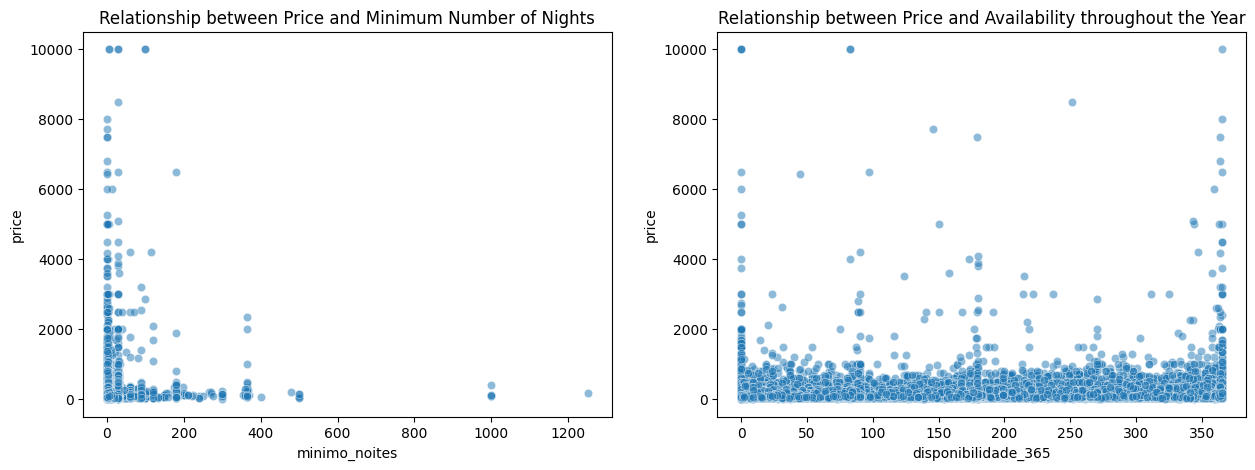

In [33]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(data=dataset, x='minimo_noites', y='price', alpha=0.5, ax=axes[0])
sns.scatterplot(data=dataset, x='disponibilidade_365', y='price', alpha=0.5, ax=axes[1])

axes[0].set_title("Relationship between Price and Minimum Number of Nights")
axes[1].set_title("Relationship between Price and Availability throughout the Year")

When observing the graphs above, it is not possible to clearly identify any relationship between the variables `minimo_noites` and `disponibilidade_365` with the variable `price`. As a second step, we will analyze the correlation matrix, using the Pearson method. The correlation will help us understand if there is any dependency or statistical relationship between the variables. One detail about the Pearson correlation is that this measure is very sensitive to outliers, so we need to remove them to perform the test. To remove them, we will use the [Tukey method](https://medium.com/@lucapqg/como-detectar-e-tratar-outliers-com-python-ca2cf088c160#:~:text=M%C3%A9todo%20de%20Tukey,%F0%9D%90%BF%F0%9D%91%A0%F0%9D%91%A2%F0%9D%91%9D%20%3D%20%F0%9D%91%843%20%2B%20(1.5%20%E2%88%97%20%F0%9D%90%BC%F0%9D%91%84%F0%9D%91%85)), which consists of defining the lower and upper limits from the interquartile (IQR) and the first (Q1) and third (Q3) quartiles.

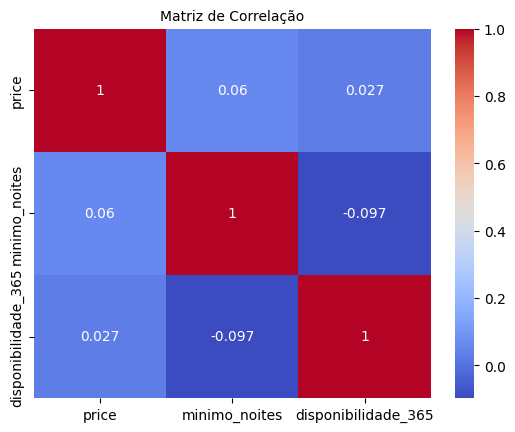

In [34]:
df = dataset[['price', 'minimo_noites','disponibilidade_365']].copy()

# Calculating quartiles and lower and upper limits
q1_price, q3_price = df['price'].quantile([0.25, 0.75])
iqr_price = q3_price - q1_price
inf_price, sup_price = q1_price - 1.5 * iqr_price, q3_price + 1.5 * iqr_price

q1_min, q3_min = df['minimo_noites'].quantile([0.25, 0.75])
iqr_min = q3_min - q1_min
inf_min, sup_min = q1_min - 1.5 * iqr_min, q3_min + 1.5 * iqr_min

# Filtering the dataset
df = df[
    (df['price'] >= inf_price) & (df['price'] <= sup_price) &
    (df['minimo_noites'] >= inf_min) & (df['minimo_noites'] <= sup_min)
]

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação", fontsize=10)
plt.show()

According to the correlation matrix, the variables did not demonstrate statistically significant importance in the price. To conclude, we will perform a linear regression test using the statsmodels library. The test will tell us how much it is possible to determine the price from `minimo_noites` and `disponibilidade_365`.

In [35]:
X = df[['minimo_noites', 'disponibilidade_365']]
X = sm.add_constant(X)
y = df['price']

# Regressão linear
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     93.51
Date:                Wed, 29 Jan 2025   Prob (F-statistic):           3.06e-41
Time:                        11:00:46   Log-Likelihood:            -2.2348e+05
No. Observations:               39737   AIC:                         4.470e+05
Df Residuals:                   39734   BIC:                         4.470e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 111.1165    

From the results we can say that the variables `minimo_noites` and `disponibilidade_365` do not interfere much in the price, considering that the 'R-squared' value is very small (0.005), which means that only 0.5% of the variation in `price` is explained by the predictors, and the same goes for the 'Adj. R-squared'.

#### 3. Is there a pattern in the text of the place name for higher-priced places?

First, you will need to find which places have the highest price. To determine the places with the highest prices, you will create a table with the 90% quantile value, using the `bairro_group` and `room_type` columns. This table will serve as a filter for selecting the highest-priced listings.

In [36]:
df = dataset.copy()

In [37]:
quantil_90_price = df.pivot_table(values='price', index='bairro_group', columns='room_type', aggfunc=lambda x: x.quantile(0.90))
quantil_90_price.sort_values(by='Entire home/apt', ascending=False, inplace=True)
quantil_90_price

room_type,Entire home/apt,Private room,Shared room
bairro_group,,,
Manhattan,399.0,175.0,147.3
Brooklyn,280.0,105.0,85.0
Queens,250.0,100.0,99.3
Staten Island,250.0,100.0,106.0
Bronx,200.0,95.0,80.5


From the table above, it is possible to see that, in the 90% quantile, the most expensive rentals are for houses and apartments in Manhattan. From this table, the ads with prices higher than those in the 90% quantile will be filtered, for each combination of `room_type` and `bairro_group`.

In [38]:
def filter_prices(row):
    if row['price'] > (quantil_90_price.loc[row['bairro_group'], row['room_type']]):
        return True
    else:
        return False

By applying the filter, with the function above, data was obtained for ads with the highest prices in each `room_type` and `bairro_group` scenario. With this data, it will be possible to search for the title of the ads, present in the `name` column, to see if there is any pattern in the text for places with the highest value.

In [39]:
# Applying the filter to the dataset
dataset_filtered = df[df.apply(filter_prices, axis=1)].copy()
dataset_filtered.head(2)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
19,7801,Sweet and Spacious Brooklyn Loft,21207,Chaya,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,3,9,1,0
20,8024,CBG CtyBGd HelpsHaiti rm#1:1-4,22486,Lisel,Brooklyn,Park Slope,40.68069,-73.97706,Private room,130,2,130,6,347


In [40]:
dataset_filtered.shape

(4686, 14)

The following strategy will be used to search for patterns:

* All words will be converted to lowercase;
* In each entry in the `nome` column, the following will be removed: punctuation marks, stop words and numbers;
* A list of lists will be created, containing each filtered word, for each entry in the `nome` column;
* The words will be counted, and at the end a dictionary with the 50 most frequent words will be obtained;

In [41]:
# Filtering words and putting them in lowercase
ad_names = dataset_filtered['nome'].apply(lambda x: re.findall(r'\b\w{4,}\b', str(x).lower()))

# Creating a list with words and counting them
ad_names = np.concatenate(ad_names.values).tolist()
words_list = dict(Counter(ad_names).most_common(50))
words_list

{'bedroom': 677,
 'private': 573,
 'room': 554,
 'apartment': 437,
 'loft': 426,
 'brooklyn': 385,
 'with': 375,
 'williamsburg': 354,
 'luxury': 347,
 'manhattan': 336,
 'park': 294,
 'spacious': 258,
 'home': 220,
 'bath': 219,
 'beautiful': 219,
 'cozy': 211,
 'duplex': 209,
 'midtown': 197,
 'suite': 194,
 'village': 193,
 'modern': 181,
 'townhouse': 171,
 'near': 171,
 'east': 167,
 'west': 163,
 'heart': 161,
 'central': 161,
 'studio': 161,
 'brownstone': 159,
 'house': 157,
 'large': 155,
 'sunny': 150,
 'square': 137,
 'location': 133,
 'huge': 126,
 'from': 126,
 'garden': 123,
 'times': 115,
 'soho': 110,
 'amazing': 106,
 'bright': 105,
 'penthouse': 104,
 'views': 101,
 'city': 96,
 'view': 96,
 'terrace': 96,
 'prime': 93,
 'floor': 89,
 'york': 87,
 'side': 85}

When analyzing the most frequent words, we notice the predominance of standardized ad words such as: studio, bedroom, apartment, village, etc. In addition to these, there are also words that describe characteristics of the place's standard of living: luxury, modern, spacious, beautiful, amazing, prime, etc. For a more in-depth analysis, a graph and a comparative table were created to visualize the difference in average prices between ads that use words associated with luxury standards and those that do not.

In [42]:
results = []

# Iterating over the list of words
for word in words_list.keys():
    # Calculating the average price of ads containing the word
    mean_has = dataset_filtered[dataset_filtered['nome'].str.contains(word, case=False, na=False)]['price'].mean()

    # Calculating the average price of ads that do not contain the word
    mean_no_has = dataset_filtered[~dataset_filtered['nome'].str.contains(word, case=False, na=False)]['price'].mean()

    # Saving results to a dictionary list
    results.append({'word': word, 'has': mean_has, 'no_has': mean_no_has})

# Creating a dataframe with the results
table = pd.DataFrame(results)
table.set_index('word', inplace=True)

# Creating a new column with the ratio between the average prices
table['ratio'] = table['has']/table['no_has']
table.sort_values(by='ratio', ascending=False, inplace=True)

The table was created by analyzing the average prices of ads that do or do not contain any of the 50 filtered words. For each word, the average price of ads that contain it and those that do not contain it was calculated. The results were then organized into a DataFrame, including an additional column with the ratio between the average prices, allowing direct comparison. This column was used to order the words, and those with a positive ratio were selected to create the comparative graph below.

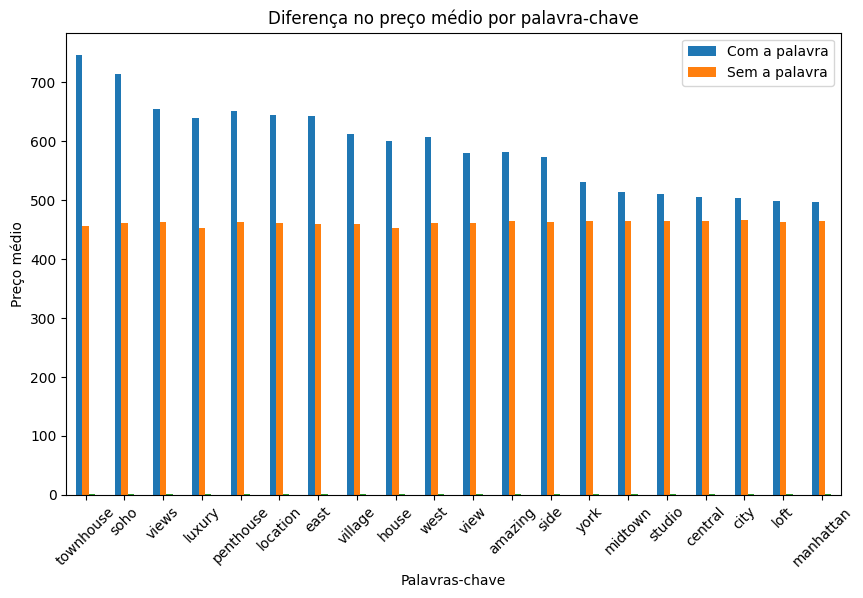

In [43]:
table.iloc[:20].plot(kind='bar', figsize=(10, 6))
plt.title('Diferença no preço médio por palavra-chave')
plt.xlabel('Palavras-chave')
plt.ylabel('Preço médio')
plt.xticks(rotation=45)
plt.legend(['Com a palavra', 'Sem a palavra'])
plt.show()

The results indicate that advertisements that use words associated with luxury standards, such as 'luxury', 'amazing' and 'townhouse' or with luxurious areas such as 'Soho', 'Chelsea' and 'Midtown', mostly have significantly higher average prices than those that do not use these words. This trend suggests that these words can be used strategically to attract an audience willing to pay more for features perceived as premium or exclusive. The graph generated from the price ratio reinforces this association. This analysis highlights the influence of the use of specific words on the perception and valuation of properties, and can be applied to the development of more effective marketing strategies."

This Exploratory Data Analysis allowed us to understand the characteristics and particularities of the data, the next step is predictive modeling, contained in this notebook: [Predictive_Modeling.ipynb](Predictive_Modeling.ipynb).